In [1]:
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.sampler.MALA import MALA
import jax
import jax.numpy as jnp  # JAX NumPy
from jax.scipy.special import logsumexp
import numpy as np

from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.nfmodel.utils import *
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys

from flowMC.nfmodel.realNVP import RealNVP

from functools import partial

/home/markc/sampling/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/markc/sampling/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

2023-05-15 14:13:40.362864: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [2]:
import corner
import matplotlib.pyplot as plt

In [3]:
@partial(jnp.vectorize, signature='(n),(),(),()->(n)')
def Gaussian_1D_raw(x, A, mu, sig):
    return A * jnp.exp(-0.5 * ((x - mu) / sig) ** 2)

@partial(jnp.vectorize, signature='(n),(n)->(n)')
def Gauss_norm_fac(A, sig):
    return (A * sig * jnp.sqrt(2 * jnp.pi))

# def add_Gaussian_1D(i, Gauss_val):
#     x, G, norm_fac, A_arr, mu_arr, sig_arr = Gauss_val
#     A = A_arr[i]
#     mu = mu_arr[i]
#     sig = sig_arr[i]
#     G += Gaussian_1D_raw(x, A, mu, sig)
#     norm_fac += Gauss_norm_fac(A, sig)
#     return (x, G, norm_fac, A_arr, mu_arr, sig_arr)

# def Gaussian_mixture(x, A, mu, sig):
#     Gauss_val = (x, 0, 0, A, mu, sig)
#     Gauss_val = jax.lax.fori_loop(0, len(mu), add_Gaussian_1D, Gauss_val)
#     return Gauss_val[1] * Gauss_val[2]

def Gaussian_mixture_raw(x, A, mu, sig):
    Gs = Gaussian_1D_raw(x, A, mu, sig)
    norm_facs = Gauss_norm_fac(A, sig)
    return jnp.sum(Gs, axis = 0)/jnp.sum(norm_facs, axis = 0)

def Gaussian_mixture(x, params):
    A = params[0::3]
    mu = params[1::3]
    sig = params[2::3]
    return Gaussian_mixture_raw(x, A, mu, sig)

In [16]:
A_arr = jnp.array([0.9, 0.3])
mu_arr = jnp.array([-3.0, 3.0])
sig_arr = jnp.array([0.8, 0.5])
params =jnp.ravel(jnp.column_stack((A_arr, mu_arr, sig_arr)))

x_arr = jnp.linspace(-5, 5, 1000)

In [17]:
G = Gaussian_mixture(x_arr, params)

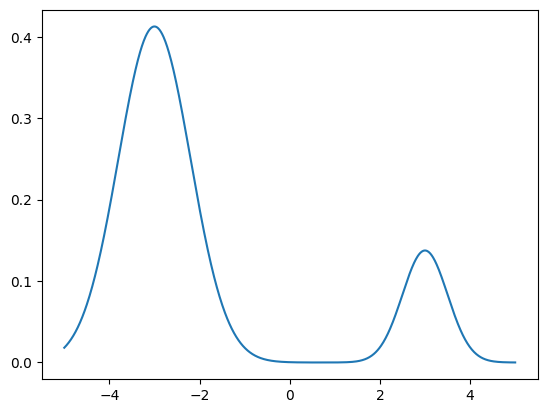

In [18]:
plt.plot(x_arr, G)

In [19]:
min_val = jnp.min(x_arr)
max_val = jnp.max(x_arr)
C = jnp.max(G)*1.1

sample_trials = 10000
seed = 3639
key = jax.random.PRNGKey(seed)
x_rand = jax.random.uniform(key, shape = (sample_trials,), minval = min_val, maxval = max_val)
key, subkey = jax.random.split(key)
y_rand = jax.random.uniform(subkey, shape = (sample_trials,), minval = 0, maxval = C)
P = Gaussian_mixture(x_rand, params)
samples = x_rand[P > y_rand]

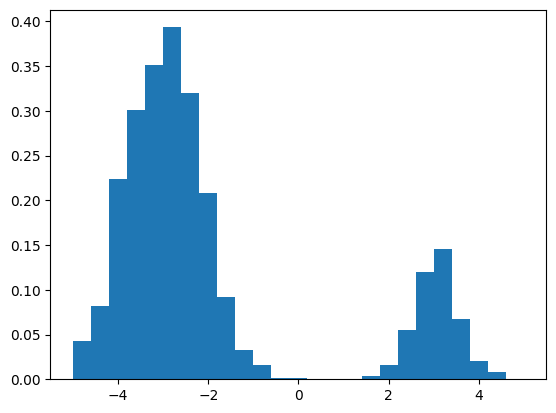

In [20]:
hist = plt.hist(samples, bins = 25, range = (min_val, max_val), density = True)

In [21]:
def log_likelihood(params, data):
    return jnp.sum(jnp.log(Gaussian_mixture(data, params)))

In [33]:
n_dim = 6
n_chains = 20
n_loop_training = 30
n_loop_production = 10
n_local_steps = 100
n_global_steps = 100
learning_rate = 0.001
momentum = 0.9
num_epochs = 30
batch_size = 10000

data = samples

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1

MALA_Sampler = MALA(log_likelihood, True, {"step_size": 0.1})
# model = RQSpline(n_dim, 4, [32, 32], 8)

In [34]:
n_layer = 10  # number of coupling layers
n_hidden = 128  # with of hidden layers in MLPs parametrizing coupling layers

model = RealNVP(n_layer, n_dim, n_hidden)

In [35]:
print("Initializing sampler class")

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    data,
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

Initializing sampler class
jit is requested, precompiling kernels and update...


In [36]:
nf_sampler.sample(initial_position, data)
summary = nf_sampler.get_sampler_state(training=True)
chains, log_prob, local_accs, global_accs, loss_vals = summary.values() 
nf_samples = nf_sampler.sample_flow(10000)

print(
    "chains shape: ",
    chains.shape,
    "local_accs shape: ",
    local_accs.shape,
    "global_accs shape: ",
    global_accs.shape,
)

chains = np.array(chains)
nf_samples = np.array(nf_samples[1])
loss_vals = np.array(loss_vals)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:  23%|██▎       | 7/30 [01:13<03:28,  9.09s/it]

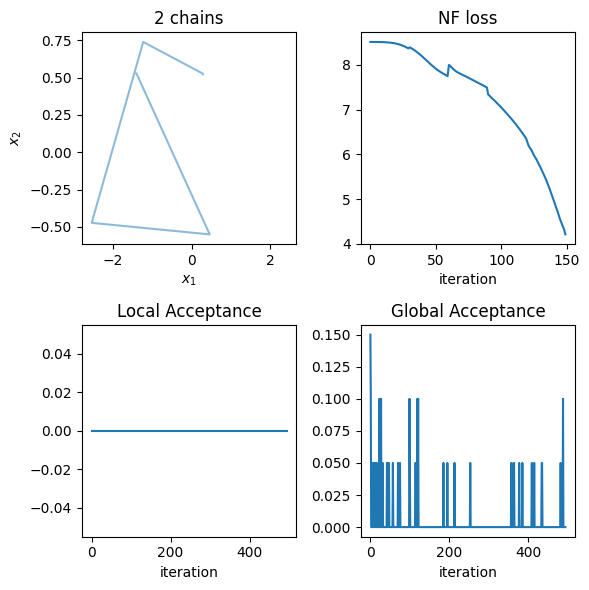

In [31]:
# Plot one chain to show the jump
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2 chains")
plt.plot(chains[0, :, 0], chains[0, :, 1], alpha=0.5)
plt.plot(chains[1, :, 0], chains[1, :, 1], alpha=0.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

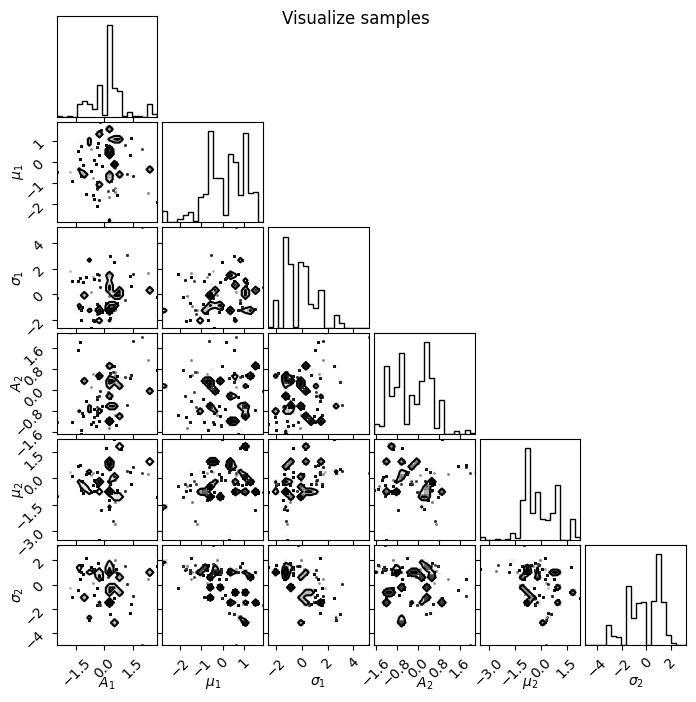

In [32]:
labels = ["$A_1$", "$\mu_1$", "$\sigma_1$", "$A_2$", "$\mu_2$", "$\sigma_2$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

In [28]:
params

Array([ 0.9, -3. ,  0.8,  0.3,  3. ,  0.5], dtype=float32)

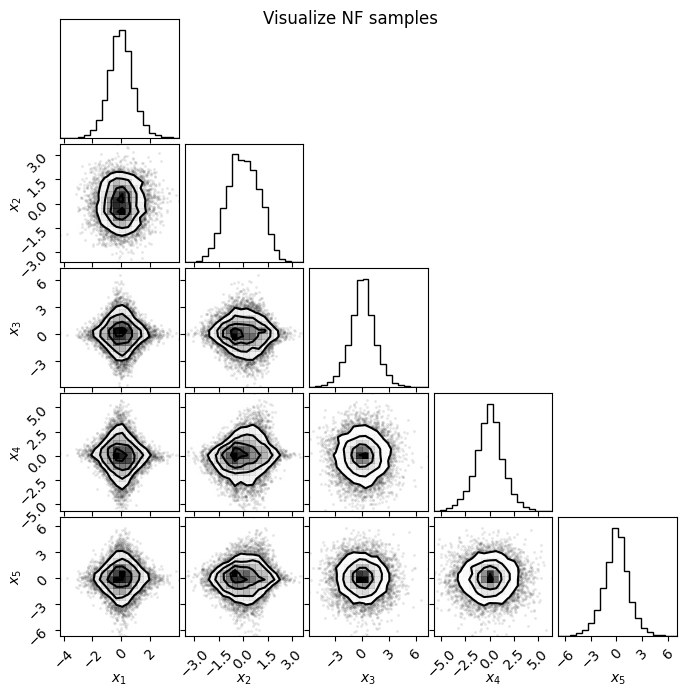

In [8]:
# Plot Nf samples
figure = corner.corner(nf_samples, labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"])
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()